In [1]:
# importing the libraries
import numpy as np

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

import pickle
def load_data(in_dir):
    f = open(in_dir,'rb')
    train_data,train_label,test_data,test_label,valid_data,valid_label,pernums_valid = pickle.load(f)
    return train_data,train_label,test_data,test_label,valid_data,valid_label,pernums_valid

# data_path = 'adress_512.pkl'
data_path = 'adress_Att_Net.pkl'
checkpoint = 'checkpoint/'

train_data,train_label,test_data,test_label,valid_data,valid_label,pernums_valid = load_data(data_path)

# converting training images into torch format
train_x = train_data
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_label
train_y = train_y.reshape(2379).astype(float);
train_y = torch.from_numpy(train_y)


# shape of training data
# train_x.shape, train_y.shape
from torch.utils.data import TensorDataset, DataLoader

# my_x = [np.array([[1.0,2],[3,4]]),np.array([[5.,6],[7,8]])] # a list of numpy arrays
# my_y = [np.array([4.]), np.array([2.])] # another list of numpy arrays (targets)

# tensor_x = torch.Tensor(my_x) # transform to torch tensor
# tensor_y = torch.Tensor(my_y)

CTX = torch.device('cuda')

train_dataset = TensorDataset(train_x.to(CTX),train_y.to(CTX)) # create your datset

 # create your dataloader


In [2]:
# converting training images into torch format
val_x = valid_data
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = valid_label
val_y = val_y.reshape(297).astype(float);
val_y = torch.from_numpy(val_y)
# shape of training data

val_dataset = TensorDataset(val_x,val_y) # create your datset

In [3]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 64
val_size = 297
# train_size = train_x.size(0) - val_size 

# train_data,val_data = random_split(dataset,[train_size,val_size])
# print(f"Length of Train Data : {len(train_data)}")
# print(f"Length of Validation Data : {len(val_data)}")

#output
#Length of Train Data : 2379
#Length of Validation Data : 297

#load the train and validation into batches.
train_dl = DataLoader(train_dataset,batch_size, shuffle = True, num_workers = 0)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers = 0)

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images.to(CTX))                  # Generate predictions
        loss = F.cross_entropy(out, labels.to(torch.int64).cuda()) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images.to(CTX))                    # Generate predictions
        loss = F.cross_entropy(out, labels.to(torch.int64).cuda())   # Calculate loss
        acc = accuracy(out, labels.to(torch.int64).cuda())           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [5]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
#         print(x.shape())
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out
    
    
class Att_Net(ImageClassificationBase):   
    def __init__(self):
        super(Att_Net, self).__init__()
        #The LW_CNN module utilizes three convolutions (C), two max-pooling
        # (MP), one average-pooling (AP), and one batch normalization
        # (BN) layer.
        self.LW_CNN = Sequential(
            # Defining a 2D convolution layer
#             Conv2d(300, 256, kernel_size=3, stride=1, padding=1),
#             BatchNorm2d(256),
#             ReLU(inplace=True),
#             MaxPool2d(kernel_size=2, stride=2),
#             # Defining another 2D convolution layer
#             Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
#             BatchNorm2d(128),
#             ReLU(inplace=True),
#             MaxPool2d(kernel_size=1, stride=1),
            
              #C1, we used 120 number of kernels with size (11
              # × 11) using (4 × 4) stride setting without padding to extract
              # initially hidden patterns from input data. 
              Conv2d(3, 120, kernel_size=(11,11), stride=(4,4), padding=0),
              MaxPool2d(kernel_size=(3,3), stride=None),
              Conv2d(120, 256, kernel_size=(5,5), stride=(1,1), padding='same'),
              MaxPool2d(kernel_size=(3,3)),
              Conv2d(256, 384, kernel_size=(3,3), padding='same'),
#               MaxPool2d(kernel_size=1, stride=0),
#               Conv2d(128, 1, kernel_size=(3,3), stride=(1,1), padding='same'),
              torch.nn.AvgPool2d(kernel_size=(3,3), stride=1),
              BatchNorm2d(384),
              ReLU(inplace=True),
        )

        self.linear_layers = Sequential(
            Linear(384 * 12 * 1, 256),
            Linear(256, 64),
            Linear(64, 2),
        )

        self.attention = CBAM(gate_channels=384)

    # Defining the forward pass    
    def forward(self, x):
        x = x.view(-1, x.size(3),x.size(2),x.size(1))
#         print(x.size)
        x = self.LW_CNN(x)
        x = self.attention(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [6]:
# defining the model
model = Att_Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Att_Net(
  (LW_CNN): Sequential(
    (0): Conv2d(3, 120, kernel_size=(11, 11), stride=(4, 4))
    (1): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(120, 256, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (3): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): AvgPool2d(kernel_size=(3, 3), stride=1, padding=0)
    (6): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=4608, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
  (attention): CBAM(
    (ChannelGate): ChannelGate(
      (mlp): Sequential(
        (0): Flatten()
        (1): Linear(in_features=384, out_features=24, bias=True)
  

In [7]:
from torchsummary import summary
summary(model, (512, 128, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 120, 30, 126]          43,680
         MaxPool2d-2          [-1, 120, 10, 42]               0
            Conv2d-3          [-1, 256, 10, 42]         768,256
         MaxPool2d-4           [-1, 256, 3, 14]               0
            Conv2d-5           [-1, 384, 3, 14]         885,120
         AvgPool2d-6           [-1, 384, 1, 12]               0
       BatchNorm2d-7           [-1, 384, 1, 12]             768
              ReLU-8           [-1, 384, 1, 12]               0
           Flatten-9                  [-1, 384]               0
           Linear-10                   [-1, 24]           9,240
             ReLU-11                   [-1, 24]               0
           Linear-12                  [-1, 384]           9,600
          Flatten-13                  [-1, 384]               0
           Linear-14                   

C:\Users\Asus\anaconda3\envs\tf-btp\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [9]:
# CTX = torch.device('cuda')
# train_dl.to(CTX)  #train_dataset.train_data is a Tensor(input data)
# # train_dl.train_labels.to(CTX)
# # val_dl.train_data.to(CTX)  #train_dataset.train_data is a Tensor(input data)
# # val_dl.train_labels.to(CTX)
num_epochs = 5000
opt_func = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 0.7140, val_loss: 0.6931, val_acc: 0.5434
Epoch [1], train_loss: 0.6822, val_loss: 0.6900, val_acc: 0.5272
Epoch [2], train_loss: 0.6762, val_loss: 0.6604, val_acc: 0.5441
Epoch [3], train_loss: 0.6870, val_loss: 0.7270, val_acc: 0.4533
Epoch [4], train_loss: 0.6686, val_loss: 0.6693, val_acc: 0.5678
Epoch [5], train_loss: 0.6643, val_loss: 0.6868, val_acc: 0.5324
Epoch [6], train_loss: 0.6603, val_loss: 0.6781, val_acc: 0.5298
Epoch [7], train_loss: 0.6600, val_loss: 0.6627, val_acc: 0.5324
Epoch [8], train_loss: 0.6578, val_loss: 0.6555, val_acc: 0.5243
Epoch [9], train_loss: 0.6640, val_loss: 0.6592, val_acc: 0.5350
Epoch [10], train_loss: 0.6591, val_loss: 0.6499, val_acc: 0.5350
Epoch [11], train_loss: 0.6584, val_loss: 0.6588, val_acc: 0.5321
Epoch [12], train_loss: 0.6556, val_loss: 0.6524, val_acc: 0.5321
Epoch [13], train_loss: 0.6599, val_loss: 0.6579, val_acc: 0.5721
Epoch [14], train_loss: 0.6568, val_loss: 0.6556, val_acc: 0.5402
Epoch [15], train_lo

Epoch [124], train_loss: 0.1045, val_loss: 3.1856, val_acc: 0.6192
Epoch [125], train_loss: 0.0912, val_loss: 1.5764, val_acc: 0.6261
Epoch [126], train_loss: 0.0872, val_loss: 2.2893, val_acc: 0.6498
Epoch [127], train_loss: 0.0959, val_loss: 1.7612, val_acc: 0.5779
Epoch [128], train_loss: 0.0782, val_loss: 2.0572, val_acc: 0.6362
Epoch [129], train_loss: 0.1287, val_loss: 1.4940, val_acc: 0.6258
Epoch [130], train_loss: 0.0864, val_loss: 2.1198, val_acc: 0.6127
Epoch [131], train_loss: 0.0876, val_loss: 2.5121, val_acc: 0.5968
Epoch [132], train_loss: 0.0570, val_loss: 4.2946, val_acc: 0.5783
Epoch [133], train_loss: 0.1345, val_loss: 1.7019, val_acc: 0.5682
Epoch [134], train_loss: 0.0668, val_loss: 2.4816, val_acc: 0.6098
Epoch [135], train_loss: 0.0857, val_loss: 2.0865, val_acc: 0.6026
Epoch [136], train_loss: 0.0887, val_loss: 2.2701, val_acc: 0.6108
Epoch [137], train_loss: 0.1802, val_loss: 1.6528, val_acc: 0.5838
Epoch [138], train_loss: 0.0887, val_loss: 1.8256, val_acc: 0.

Epoch [247], train_loss: 0.0000, val_loss: 4.7786, val_acc: 0.6336
Epoch [248], train_loss: 0.0000, val_loss: 4.9350, val_acc: 0.6258
Epoch [249], train_loss: 0.0000, val_loss: 4.8252, val_acc: 0.6339
Epoch [250], train_loss: 0.0000, val_loss: 5.0877, val_acc: 0.6150
Epoch [251], train_loss: 0.0000, val_loss: 5.1540, val_acc: 0.6098
Epoch [252], train_loss: 0.0000, val_loss: 5.0085, val_acc: 0.6124
Epoch [253], train_loss: 0.0000, val_loss: 4.9708, val_acc: 0.6124
Epoch [254], train_loss: 0.0000, val_loss: 5.1149, val_acc: 0.6124
Epoch [255], train_loss: 0.0000, val_loss: 4.9669, val_acc: 0.6150
Epoch [256], train_loss: 0.0000, val_loss: 5.1123, val_acc: 0.6176
Epoch [257], train_loss: 0.0000, val_loss: 5.0266, val_acc: 0.6124
Epoch [258], train_loss: 0.0000, val_loss: 5.1605, val_acc: 0.6124
Epoch [259], train_loss: 0.0003, val_loss: 5.2878, val_acc: 0.6469
Epoch [260], train_loss: 0.2975, val_loss: 1.7668, val_acc: 0.5936
Epoch [261], train_loss: 0.2518, val_loss: 1.3396, val_acc: 0.

Epoch [370], train_loss: 0.0000, val_loss: 4.6716, val_acc: 0.5851
Epoch [371], train_loss: 0.0000, val_loss: 4.6203, val_acc: 0.5955
Epoch [372], train_loss: 0.0000, val_loss: 4.6573, val_acc: 0.5825
Epoch [373], train_loss: 0.0000, val_loss: 4.5749, val_acc: 0.5929
Epoch [374], train_loss: 0.0000, val_loss: 4.6517, val_acc: 0.5929
Epoch [375], train_loss: 0.0000, val_loss: 4.8068, val_acc: 0.5958
Epoch [376], train_loss: 0.0000, val_loss: 4.7636, val_acc: 0.5877
Epoch [377], train_loss: 0.0000, val_loss: 4.6607, val_acc: 0.5929
Epoch [378], train_loss: 0.0001, val_loss: 4.7795, val_acc: 0.5958
Epoch [379], train_loss: 0.0057, val_loss: 8.2566, val_acc: 0.5428
Epoch [380], train_loss: 0.0745, val_loss: 1.5744, val_acc: 0.5568
Epoch [381], train_loss: 0.1089, val_loss: 2.5463, val_acc: 0.6261
Epoch [382], train_loss: 0.0874, val_loss: 4.7785, val_acc: 0.5994
Epoch [383], train_loss: 0.0801, val_loss: 2.0121, val_acc: 0.5646
Epoch [384], train_loss: 0.0479, val_loss: 3.3132, val_acc: 0.

Epoch [493], train_loss: 0.0685, val_loss: 1.6092, val_acc: 0.5591
Epoch [494], train_loss: 0.0169, val_loss: 2.9847, val_acc: 0.6157
Epoch [495], train_loss: 0.0214, val_loss: 3.0938, val_acc: 0.6179
Epoch [496], train_loss: 0.0074, val_loss: 3.5336, val_acc: 0.6206
Epoch [497], train_loss: 0.0015, val_loss: 3.6368, val_acc: 0.6209
Epoch [498], train_loss: 0.0005, val_loss: 3.6033, val_acc: 0.6261
Epoch [499], train_loss: 0.0004, val_loss: 3.8703, val_acc: 0.6287
Epoch [500], train_loss: 0.0002, val_loss: 3.9470, val_acc: 0.6206
Epoch [501], train_loss: 0.0001, val_loss: 3.8629, val_acc: 0.6313
Epoch [502], train_loss: 0.0001, val_loss: 4.0135, val_acc: 0.6206
Epoch [503], train_loss: 0.0001, val_loss: 3.9691, val_acc: 0.6206
Epoch [504], train_loss: 0.0001, val_loss: 4.1485, val_acc: 0.6179
Epoch [505], train_loss: 0.0001, val_loss: 4.1511, val_acc: 0.6124
Epoch [506], train_loss: 0.0001, val_loss: 4.1432, val_acc: 0.6098
Epoch [507], train_loss: 0.0001, val_loss: 4.1424, val_acc: 0.

Epoch [616], train_loss: 0.0000, val_loss: 3.8040, val_acc: 0.6254
Epoch [617], train_loss: 0.0000, val_loss: 3.8757, val_acc: 0.6284
Epoch [618], train_loss: 0.0000, val_loss: 3.8640, val_acc: 0.6254
Epoch [619], train_loss: 0.0000, val_loss: 3.8606, val_acc: 0.6232
Epoch [620], train_loss: 0.0106, val_loss: 4.8758, val_acc: 0.6017
Epoch [621], train_loss: 0.1626, val_loss: 1.5722, val_acc: 0.6101
Epoch [622], train_loss: 0.0809, val_loss: 2.7436, val_acc: 0.6020
Epoch [623], train_loss: 0.1468, val_loss: 1.9640, val_acc: 0.6124
Epoch [624], train_loss: 0.0565, val_loss: 2.3300, val_acc: 0.6023
Epoch [625], train_loss: 0.0284, val_loss: 1.8372, val_acc: 0.5965
Epoch [626], train_loss: 0.0278, val_loss: 3.3600, val_acc: 0.6258
Epoch [627], train_loss: 0.0239, val_loss: 2.9261, val_acc: 0.5968
Epoch [628], train_loss: 0.0058, val_loss: 2.8077, val_acc: 0.6371
Epoch [629], train_loss: 0.0009, val_loss: 3.0108, val_acc: 0.6394
Epoch [630], train_loss: 0.0002, val_loss: 3.1157, val_acc: 0.

Epoch [739], train_loss: 0.0000, val_loss: 4.0573, val_acc: 0.6176
Epoch [740], train_loss: 0.0000, val_loss: 4.0185, val_acc: 0.6124
Epoch [741], train_loss: 0.0000, val_loss: 4.1100, val_acc: 0.6150
Epoch [742], train_loss: 0.0000, val_loss: 3.9904, val_acc: 0.6098
Epoch [743], train_loss: 0.0000, val_loss: 3.9741, val_acc: 0.6179
Epoch [744], train_loss: 0.0023, val_loss: 5.6311, val_acc: 0.5991
Epoch [745], train_loss: 0.0697, val_loss: 3.0302, val_acc: 0.5838
Epoch [746], train_loss: 0.1129, val_loss: 2.1246, val_acc: 0.6228
Epoch [747], train_loss: 0.0504, val_loss: 2.2392, val_acc: 0.5854
Epoch [748], train_loss: 0.0463, val_loss: 2.9280, val_acc: 0.6098
Epoch [749], train_loss: 0.0162, val_loss: 2.8942, val_acc: 0.6098
Epoch [750], train_loss: 0.0038, val_loss: 2.7405, val_acc: 0.5910
Epoch [751], train_loss: 0.0008, val_loss: 3.4505, val_acc: 0.6313
Epoch [752], train_loss: 0.0011, val_loss: 3.8241, val_acc: 0.6098
Epoch [753], train_loss: 0.0018, val_loss: 4.1521, val_acc: 0.

Epoch [862], train_loss: 0.0000, val_loss: 4.8153, val_acc: 0.6232
Epoch [863], train_loss: 0.0000, val_loss: 4.7991, val_acc: 0.6261
Epoch [864], train_loss: 0.0000, val_loss: 4.6913, val_acc: 0.6342
Epoch [865], train_loss: 0.0000, val_loss: 4.6806, val_acc: 0.6313
Epoch [866], train_loss: 0.0000, val_loss: 4.7787, val_acc: 0.6284
Epoch [867], train_loss: 0.0000, val_loss: 4.7236, val_acc: 0.6206
Epoch [868], train_loss: 0.0003, val_loss: 4.8140, val_acc: 0.6127
Epoch [869], train_loss: 0.2391, val_loss: 1.1264, val_acc: 0.5646
Epoch [870], train_loss: 0.1880, val_loss: 5.5308, val_acc: 0.5483
Epoch [871], train_loss: 0.1492, val_loss: 1.9165, val_acc: 0.5779
Epoch [872], train_loss: 0.0757, val_loss: 2.5225, val_acc: 0.6528
Epoch [873], train_loss: 0.0448, val_loss: 2.7510, val_acc: 0.6206
Epoch [874], train_loss: 0.1353, val_loss: 1.1025, val_acc: 0.6105
Epoch [875], train_loss: 0.0617, val_loss: 2.2933, val_acc: 0.6176
Epoch [876], train_loss: 0.0344, val_loss: 1.4071, val_acc: 0.

Epoch [985], train_loss: 0.0000, val_loss: 5.3557, val_acc: 0.6049
Epoch [986], train_loss: 0.0000, val_loss: 5.3748, val_acc: 0.6052
Epoch [987], train_loss: 0.0000, val_loss: 5.3144, val_acc: 0.6075
Epoch [988], train_loss: 0.0000, val_loss: 5.2277, val_acc: 0.6075
Epoch [989], train_loss: 0.0000, val_loss: 5.4076, val_acc: 0.6157
Epoch [990], train_loss: 0.0000, val_loss: 5.5005, val_acc: 0.6049
Epoch [991], train_loss: 0.0000, val_loss: 5.3161, val_acc: 0.6075
Epoch [992], train_loss: 0.0000, val_loss: 5.4196, val_acc: 0.5971
Epoch [993], train_loss: 0.0000, val_loss: 5.3777, val_acc: 0.5994
Epoch [994], train_loss: 0.0000, val_loss: 5.4585, val_acc: 0.6049
Epoch [995], train_loss: 0.0000, val_loss: 5.2581, val_acc: 0.6049
Epoch [996], train_loss: 0.0000, val_loss: 5.4610, val_acc: 0.6157
Epoch [997], train_loss: 0.0004, val_loss: 5.8270, val_acc: 0.6157
Epoch [998], train_loss: 0.1513, val_loss: 1.7686, val_acc: 0.5838
Epoch [999], train_loss: 0.0923, val_loss: 2.5897, val_acc: 0.

Epoch [1106], train_loss: 0.0000, val_loss: 4.4433, val_acc: 0.5939
Epoch [1107], train_loss: 0.0000, val_loss: 4.4737, val_acc: 0.5965
Epoch [1108], train_loss: 0.0000, val_loss: 4.4851, val_acc: 0.5939
Epoch [1109], train_loss: 0.0000, val_loss: 4.4556, val_acc: 0.5965
Epoch [1110], train_loss: 0.0000, val_loss: 4.5088, val_acc: 0.5965
Epoch [1111], train_loss: 0.0000, val_loss: 4.5019, val_acc: 0.5939
Epoch [1112], train_loss: 0.0000, val_loss: 4.5037, val_acc: 0.5831
Epoch [1113], train_loss: 0.0001, val_loss: 4.4923, val_acc: 0.5884
Epoch [1114], train_loss: 0.0001, val_loss: 4.7034, val_acc: 0.5854
Epoch [1115], train_loss: 0.0000, val_loss: 4.7100, val_acc: 0.5991
Epoch [1116], train_loss: 0.0000, val_loss: 4.8681, val_acc: 0.5936
Epoch [1117], train_loss: 0.0000, val_loss: 4.6689, val_acc: 0.5965
Epoch [1118], train_loss: 0.0000, val_loss: 4.8355, val_acc: 0.5936
Epoch [1119], train_loss: 0.0000, val_loss: 4.7747, val_acc: 0.5939
Epoch [1120], train_loss: 0.0000, val_loss: 4.67

Epoch [1227], train_loss: 0.0325, val_loss: 2.8391, val_acc: 0.6371
Epoch [1228], train_loss: 0.0127, val_loss: 3.0928, val_acc: 0.6479
Epoch [1229], train_loss: 0.0015, val_loss: 3.9355, val_acc: 0.6316
Epoch [1230], train_loss: 0.0011, val_loss: 4.3341, val_acc: 0.6241
Epoch [1231], train_loss: 0.0003, val_loss: 4.4226, val_acc: 0.6267
Epoch [1232], train_loss: 0.0001, val_loss: 4.4766, val_acc: 0.6293
Epoch [1233], train_loss: 0.0001, val_loss: 4.7561, val_acc: 0.6267
Epoch [1234], train_loss: 0.0000, val_loss: 4.7221, val_acc: 0.6293
Epoch [1235], train_loss: 0.0001, val_loss: 4.9328, val_acc: 0.6267
Epoch [1236], train_loss: 0.0001, val_loss: 4.8740, val_acc: 0.6319
Epoch [1237], train_loss: 0.0000, val_loss: 4.9220, val_acc: 0.6215
Epoch [1238], train_loss: 0.0000, val_loss: 4.9835, val_acc: 0.6189
Epoch [1239], train_loss: 0.0000, val_loss: 4.8980, val_acc: 0.6186
Epoch [1240], train_loss: 0.0000, val_loss: 5.0230, val_acc: 0.6267
Epoch [1241], train_loss: 0.0000, val_loss: 5.18

Epoch [1348], train_loss: 0.0000, val_loss: 6.7440, val_acc: 0.6397
Epoch [1349], train_loss: 0.0000, val_loss: 6.8713, val_acc: 0.6290
Epoch [1350], train_loss: 0.0000, val_loss: 7.1025, val_acc: 0.6423
Epoch [1351], train_loss: 0.0000, val_loss: 6.6824, val_acc: 0.6423
Epoch [1352], train_loss: 0.0000, val_loss: 6.8582, val_acc: 0.6290
Epoch [1353], train_loss: 0.0000, val_loss: 6.9018, val_acc: 0.6423
Epoch [1354], train_loss: 0.0000, val_loss: 6.9264, val_acc: 0.6423
Epoch [1355], train_loss: 0.0000, val_loss: 6.7518, val_acc: 0.6345
Epoch [1356], train_loss: 0.0000, val_loss: 7.0288, val_acc: 0.6397
Epoch [1357], train_loss: 0.0000, val_loss: 6.9532, val_acc: 0.6371
Epoch [1358], train_loss: 0.0000, val_loss: 6.8748, val_acc: 0.6449
Epoch [1359], train_loss: 0.0000, val_loss: 6.9664, val_acc: 0.6342
Epoch [1360], train_loss: 0.0000, val_loss: 6.8045, val_acc: 0.6423
Epoch [1361], train_loss: 0.0000, val_loss: 7.0360, val_acc: 0.6449
Epoch [1362], train_loss: 0.0000, val_loss: 6.97

Epoch [1469], train_loss: 0.0001, val_loss: 3.5653, val_acc: 0.6316
Epoch [1470], train_loss: 0.0001, val_loss: 3.6781, val_acc: 0.6423
Epoch [1471], train_loss: 0.0001, val_loss: 3.6434, val_acc: 0.6342
Epoch [1472], train_loss: 0.0000, val_loss: 3.7715, val_acc: 0.6449
Epoch [1473], train_loss: 0.0000, val_loss: 3.7088, val_acc: 0.6394
Epoch [1474], train_loss: 0.0000, val_loss: 3.7906, val_acc: 0.6368
Epoch [1475], train_loss: 0.0000, val_loss: 3.7802, val_acc: 0.6423
Epoch [1476], train_loss: 0.0000, val_loss: 3.8584, val_acc: 0.6261
Epoch [1477], train_loss: 0.0000, val_loss: 3.8901, val_acc: 0.6368
Epoch [1478], train_loss: 0.0000, val_loss: 3.8864, val_acc: 0.6342
Epoch [1479], train_loss: 0.0000, val_loss: 3.8910, val_acc: 0.6261
Epoch [1480], train_loss: 0.0000, val_loss: 3.9665, val_acc: 0.6368
Epoch [1481], train_loss: 0.0026, val_loss: 3.9154, val_acc: 0.6212
Epoch [1482], train_loss: 0.0667, val_loss: 1.9236, val_acc: 0.6212
Epoch [1483], train_loss: 0.0464, val_loss: 3.41

Epoch [1590], train_loss: 0.0000, val_loss: 4.7040, val_acc: 0.6339
Epoch [1591], train_loss: 0.0000, val_loss: 4.8937, val_acc: 0.6232
Epoch [1592], train_loss: 0.0000, val_loss: 4.7314, val_acc: 0.6365
Epoch [1593], train_loss: 0.0000, val_loss: 4.9158, val_acc: 0.6258
Epoch [1594], train_loss: 0.0000, val_loss: 4.8461, val_acc: 0.6232
Epoch [1595], train_loss: 0.0000, val_loss: 4.8642, val_acc: 0.6258
Epoch [1596], train_loss: 0.0000, val_loss: 4.9493, val_acc: 0.6206
Epoch [1597], train_loss: 0.0000, val_loss: 4.9626, val_acc: 0.6179
Epoch [1598], train_loss: 0.0000, val_loss: 5.0216, val_acc: 0.6258
Epoch [1599], train_loss: 0.0000, val_loss: 4.8600, val_acc: 0.6365
Epoch [1600], train_loss: 0.0000, val_loss: 4.9469, val_acc: 0.6339
Epoch [1601], train_loss: 0.0000, val_loss: 5.0845, val_acc: 0.6258
Epoch [1602], train_loss: 0.0000, val_loss: 4.8018, val_acc: 0.6339
Epoch [1603], train_loss: 0.0000, val_loss: 5.1485, val_acc: 0.6206
Epoch [1604], train_loss: 0.0000, val_loss: 4.96

Epoch [1711], train_loss: 0.0001, val_loss: 3.7925, val_acc: 0.6049
Epoch [1712], train_loss: 0.0000, val_loss: 3.8419, val_acc: 0.6023
Epoch [1713], train_loss: 0.0000, val_loss: 3.7636, val_acc: 0.6131
Epoch [1714], train_loss: 0.0038, val_loss: 3.4868, val_acc: 0.6212
Epoch [1715], train_loss: 0.0566, val_loss: 2.9982, val_acc: 0.6212
Epoch [1716], train_loss: 0.0153, val_loss: 2.4751, val_acc: 0.6394
Epoch [1717], train_loss: 0.0390, val_loss: 2.2023, val_acc: 0.5962
Epoch [1718], train_loss: 0.0019, val_loss: 2.6978, val_acc: 0.6206
Epoch [1719], train_loss: 0.0006, val_loss: 2.8766, val_acc: 0.6232
Epoch [1720], train_loss: 0.0006, val_loss: 2.9250, val_acc: 0.6313
Epoch [1721], train_loss: 0.0003, val_loss: 2.8961, val_acc: 0.6261
Epoch [1722], train_loss: 0.0004, val_loss: 2.9082, val_acc: 0.6287
Epoch [1723], train_loss: 0.0017, val_loss: 3.5866, val_acc: 0.5857
Epoch [1724], train_loss: 0.0020, val_loss: 3.1511, val_acc: 0.6342
Epoch [1725], train_loss: 0.0007, val_loss: 3.19

Epoch [1832], train_loss: 0.0000, val_loss: 4.7308, val_acc: 0.6316
Epoch [1833], train_loss: 0.0000, val_loss: 4.8310, val_acc: 0.6290
Epoch [1834], train_loss: 0.0000, val_loss: 4.9708, val_acc: 0.6397
Epoch [1835], train_loss: 0.0000, val_loss: 4.9282, val_acc: 0.6183
Epoch [1836], train_loss: 0.0000, val_loss: 4.9313, val_acc: 0.6290
Epoch [1837], train_loss: 0.0000, val_loss: 4.8863, val_acc: 0.6209
Epoch [1838], train_loss: 0.0000, val_loss: 4.9635, val_acc: 0.6209
Epoch [1839], train_loss: 0.0000, val_loss: 5.0811, val_acc: 0.6183
Epoch [1840], train_loss: 0.0000, val_loss: 5.0387, val_acc: 0.6235
Epoch [1841], train_loss: 0.0000, val_loss: 5.0031, val_acc: 0.6290
Epoch [1842], train_loss: 0.0000, val_loss: 4.9415, val_acc: 0.6290
Epoch [1843], train_loss: 0.0000, val_loss: 4.9005, val_acc: 0.6264
Epoch [1844], train_loss: 0.0000, val_loss: 5.0933, val_acc: 0.6238
Epoch [1845], train_loss: 0.0000, val_loss: 5.0536, val_acc: 0.6183
Epoch [1846], train_loss: 0.0000, val_loss: 5.13

Epoch [1953], train_loss: 0.0000, val_loss: 5.5869, val_acc: 0.6427
Epoch [1954], train_loss: 0.0000, val_loss: 5.5221, val_acc: 0.6427
Epoch [1955], train_loss: 0.0000, val_loss: 5.5872, val_acc: 0.6505
Epoch [1956], train_loss: 0.0000, val_loss: 5.6792, val_acc: 0.6508
Epoch [1957], train_loss: 0.0000, val_loss: 5.4919, val_acc: 0.6371
Epoch [1958], train_loss: 0.0000, val_loss: 5.7067, val_acc: 0.6345
Epoch [1959], train_loss: 0.0000, val_loss: 5.6779, val_acc: 0.6238
Epoch [1960], train_loss: 0.0000, val_loss: 5.5578, val_acc: 0.6427
Epoch [1961], train_loss: 0.0000, val_loss: 5.7246, val_acc: 0.6374
Epoch [1962], train_loss: 0.0000, val_loss: 5.4920, val_acc: 0.6479
Epoch [1963], train_loss: 0.0000, val_loss: 5.7233, val_acc: 0.6427
Epoch [1964], train_loss: 0.0000, val_loss: 5.7059, val_acc: 0.6508
Epoch [1965], train_loss: 0.0000, val_loss: 5.7002, val_acc: 0.6505
Epoch [1966], train_loss: 0.0000, val_loss: 5.6922, val_acc: 0.6534
Epoch [1967], train_loss: 0.0000, val_loss: 5.80

Epoch [2074], train_loss: 0.0000, val_loss: 4.5436, val_acc: 0.6069
Epoch [2075], train_loss: 0.0000, val_loss: 4.4620, val_acc: 0.6069
Epoch [2076], train_loss: 0.0000, val_loss: 4.4782, val_acc: 0.6098
Epoch [2077], train_loss: 0.0000, val_loss: 4.5845, val_acc: 0.6043
Epoch [2078], train_loss: 0.0000, val_loss: 4.4314, val_acc: 0.6072
Epoch [2079], train_loss: 0.0000, val_loss: 4.4824, val_acc: 0.6043
Epoch [2080], train_loss: 0.0000, val_loss: 4.5241, val_acc: 0.6043
Epoch [2081], train_loss: 0.0000, val_loss: 4.5172, val_acc: 0.6069
Epoch [2082], train_loss: 0.0000, val_loss: 4.5754, val_acc: 0.6069
Epoch [2083], train_loss: 0.0000, val_loss: 4.4632, val_acc: 0.6017
Epoch [2084], train_loss: 0.0000, val_loss: 4.6240, val_acc: 0.6043
Epoch [2085], train_loss: 0.0000, val_loss: 4.4929, val_acc: 0.6017
Epoch [2086], train_loss: 0.0000, val_loss: 4.3634, val_acc: 0.6017
Epoch [2087], train_loss: 0.0000, val_loss: 4.5390, val_acc: 0.6017
Epoch [2088], train_loss: 0.0000, val_loss: 4.45

Epoch [2195], train_loss: 0.0000, val_loss: 5.0737, val_acc: 0.5776
Epoch [2196], train_loss: 0.0000, val_loss: 5.0170, val_acc: 0.5854
Epoch [2197], train_loss: 0.0000, val_loss: 5.0294, val_acc: 0.5828
Epoch [2198], train_loss: 0.0000, val_loss: 5.2318, val_acc: 0.5828
Epoch [2199], train_loss: 0.0000, val_loss: 4.9193, val_acc: 0.5776
Epoch [2200], train_loss: 0.0000, val_loss: 4.8128, val_acc: 0.5802
Epoch [2201], train_loss: 0.0000, val_loss: 4.9878, val_acc: 0.5776
Epoch [2202], train_loss: 0.0000, val_loss: 5.0784, val_acc: 0.5802
Epoch [2203], train_loss: 0.0000, val_loss: 5.0663, val_acc: 0.5750
Epoch [2204], train_loss: 0.0000, val_loss: 5.0476, val_acc: 0.5828
Epoch [2205], train_loss: 0.0000, val_loss: 5.2000, val_acc: 0.5828
Epoch [2206], train_loss: 0.0000, val_loss: 5.1249, val_acc: 0.5802
Epoch [2207], train_loss: 0.0000, val_loss: 4.9903, val_acc: 0.5776
Epoch [2208], train_loss: 0.0000, val_loss: 5.1810, val_acc: 0.5802
Epoch [2209], train_loss: 0.0000, val_loss: 5.07

Epoch [2316], train_loss: 0.0663, val_loss: 3.0905, val_acc: 0.6118
Epoch [2317], train_loss: 0.0560, val_loss: 2.1777, val_acc: 0.6124
Epoch [2318], train_loss: 0.0083, val_loss: 2.5621, val_acc: 0.6069
Epoch [2319], train_loss: 0.0026, val_loss: 3.1027, val_acc: 0.6098
Epoch [2320], train_loss: 0.0005, val_loss: 3.3154, val_acc: 0.6020
Epoch [2321], train_loss: 0.0002, val_loss: 3.5741, val_acc: 0.6046
Epoch [2322], train_loss: 0.0002, val_loss: 3.6056, val_acc: 0.6046
Epoch [2323], train_loss: 0.0001, val_loss: 3.7893, val_acc: 0.6020
Epoch [2324], train_loss: 0.0001, val_loss: 3.9095, val_acc: 0.5991
Epoch [2325], train_loss: 0.0000, val_loss: 3.8550, val_acc: 0.5887
Epoch [2326], train_loss: 0.0000, val_loss: 3.8270, val_acc: 0.5994
Epoch [2327], train_loss: 0.0000, val_loss: 3.9730, val_acc: 0.5861
Epoch [2328], train_loss: 0.0000, val_loss: 3.8530, val_acc: 0.5887
Epoch [2329], train_loss: 0.0000, val_loss: 3.9248, val_acc: 0.5991
Epoch [2330], train_loss: 0.0000, val_loss: 3.91

Epoch [2437], train_loss: 0.0000, val_loss: 5.2020, val_acc: 0.5835
Epoch [2438], train_loss: 0.0000, val_loss: 5.2175, val_acc: 0.5809
Epoch [2439], train_loss: 0.0000, val_loss: 5.2141, val_acc: 0.5916
Epoch [2440], train_loss: 0.0000, val_loss: 5.2838, val_acc: 0.5942
Epoch [2441], train_loss: 0.0000, val_loss: 5.2574, val_acc: 0.5887
Epoch [2442], train_loss: 0.0000, val_loss: 5.3806, val_acc: 0.5861
Epoch [2443], train_loss: 0.0000, val_loss: 5.2712, val_acc: 0.5861
Epoch [2444], train_loss: 0.0000, val_loss: 5.3398, val_acc: 0.5968
Epoch [2445], train_loss: 0.0000, val_loss: 5.3744, val_acc: 0.5942
Epoch [2446], train_loss: 0.0000, val_loss: 5.1664, val_acc: 0.5887
Epoch [2447], train_loss: 0.0000, val_loss: 5.4219, val_acc: 0.5861
Epoch [2448], train_loss: 0.0000, val_loss: 5.3026, val_acc: 0.5861
Epoch [2449], train_loss: 0.0000, val_loss: 5.5060, val_acc: 0.5942
Epoch [2450], train_loss: 0.0000, val_loss: 5.3247, val_acc: 0.5942
Epoch [2451], train_loss: 0.0000, val_loss: 5.51

Epoch [2558], train_loss: 0.0000, val_loss: 6.5830, val_acc: 0.5698
Epoch [2559], train_loss: 0.0000, val_loss: 6.6518, val_acc: 0.5779
Epoch [2560], train_loss: 0.0000, val_loss: 6.5934, val_acc: 0.5698
Epoch [2561], train_loss: 0.0001, val_loss: 5.9945, val_acc: 0.5727
Epoch [2562], train_loss: 0.0761, val_loss: 2.3443, val_acc: 0.6052
Epoch [2563], train_loss: 0.1162, val_loss: 1.6791, val_acc: 0.6121
Epoch [2564], train_loss: 0.0392, val_loss: 1.8241, val_acc: 0.6023
Epoch [2565], train_loss: 0.0428, val_loss: 2.3327, val_acc: 0.6127
Epoch [2566], train_loss: 0.0033, val_loss: 3.1395, val_acc: 0.6072
Epoch [2567], train_loss: 0.0002, val_loss: 3.2009, val_acc: 0.6046
Epoch [2568], train_loss: 0.0001, val_loss: 3.3087, val_acc: 0.6183
Epoch [2569], train_loss: 0.0001, val_loss: 3.5085, val_acc: 0.6209
Epoch [2570], train_loss: 0.0001, val_loss: 3.4047, val_acc: 0.6049
Epoch [2571], train_loss: 0.0001, val_loss: 3.5337, val_acc: 0.6264
Epoch [2572], train_loss: 0.0000, val_loss: 3.62

Epoch [2679], train_loss: 0.0000, val_loss: 4.8346, val_acc: 0.5962
Epoch [2680], train_loss: 0.0000, val_loss: 5.0829, val_acc: 0.5962
Epoch [2681], train_loss: 0.0000, val_loss: 5.0591, val_acc: 0.5962
Epoch [2682], train_loss: 0.0000, val_loss: 4.8773, val_acc: 0.5910
Epoch [2683], train_loss: 0.0000, val_loss: 4.9660, val_acc: 0.6043
Epoch [2684], train_loss: 0.0000, val_loss: 4.9549, val_acc: 0.6017
Epoch [2685], train_loss: 0.0000, val_loss: 5.0763, val_acc: 0.6017
Epoch [2686], train_loss: 0.0000, val_loss: 5.0182, val_acc: 0.6043
Epoch [2687], train_loss: 0.0000, val_loss: 5.1658, val_acc: 0.6069
Epoch [2688], train_loss: 0.0000, val_loss: 4.9317, val_acc: 0.6069
Epoch [2689], train_loss: 0.0000, val_loss: 5.0231, val_acc: 0.6043
Epoch [2690], train_loss: 0.0000, val_loss: 5.1163, val_acc: 0.5991
Epoch [2691], train_loss: 0.0000, val_loss: 5.2658, val_acc: 0.6069
Epoch [2692], train_loss: 0.0000, val_loss: 5.0325, val_acc: 0.6069
Epoch [2693], train_loss: 0.0000, val_loss: 5.24

Epoch [2800], train_loss: 0.0000, val_loss: 5.2968, val_acc: 0.5910
Epoch [2801], train_loss: 0.0000, val_loss: 5.2787, val_acc: 0.5910
Epoch [2802], train_loss: 0.0000, val_loss: 5.2740, val_acc: 0.5831
Epoch [2803], train_loss: 0.0000, val_loss: 5.2560, val_acc: 0.5831
Epoch [2804], train_loss: 0.0000, val_loss: 5.3932, val_acc: 0.5857
Epoch [2805], train_loss: 0.0000, val_loss: 5.1762, val_acc: 0.5776
Epoch [2806], train_loss: 0.0000, val_loss: 5.4238, val_acc: 0.5988
Epoch [2807], train_loss: 0.0000, val_loss: 5.3602, val_acc: 0.5776
Epoch [2808], train_loss: 0.0000, val_loss: 5.2746, val_acc: 0.5831
Epoch [2809], train_loss: 0.0000, val_loss: 5.5408, val_acc: 0.5936
Epoch [2810], train_loss: 0.0000, val_loss: 5.5449, val_acc: 0.5936
Epoch [2811], train_loss: 0.0000, val_loss: 5.5043, val_acc: 0.5936
Epoch [2812], train_loss: 0.0000, val_loss: 5.5712, val_acc: 0.5962
Epoch [2813], train_loss: 0.0000, val_loss: 5.4849, val_acc: 0.5910
Epoch [2814], train_loss: 0.0000, val_loss: 5.55

Epoch [2921], train_loss: 0.0000, val_loss: 4.7729, val_acc: 0.6124
Epoch [2922], train_loss: 0.0000, val_loss: 5.0093, val_acc: 0.6124
Epoch [2923], train_loss: 0.0000, val_loss: 4.8359, val_acc: 0.6098
Epoch [2924], train_loss: 0.0000, val_loss: 5.0158, val_acc: 0.6072
Epoch [2925], train_loss: 0.0000, val_loss: 4.9952, val_acc: 0.6098
Epoch [2926], train_loss: 0.0000, val_loss: 4.8403, val_acc: 0.6150
Epoch [2927], train_loss: 0.0000, val_loss: 4.9472, val_acc: 0.6150
Epoch [2928], train_loss: 0.0000, val_loss: 4.9139, val_acc: 0.6124
Epoch [2929], train_loss: 0.0000, val_loss: 4.8982, val_acc: 0.6098
Epoch [2930], train_loss: 0.0000, val_loss: 5.0391, val_acc: 0.6098
Epoch [2931], train_loss: 0.0000, val_loss: 5.0441, val_acc: 0.6150
Epoch [2932], train_loss: 0.0000, val_loss: 5.0606, val_acc: 0.6098
Epoch [2933], train_loss: 0.0000, val_loss: 5.0603, val_acc: 0.6150
Epoch [2934], train_loss: 0.0000, val_loss: 5.0298, val_acc: 0.6124
Epoch [2935], train_loss: 0.0000, val_loss: 4.88

Epoch [3042], train_loss: 0.0003, val_loss: 3.3630, val_acc: 0.5939
Epoch [3043], train_loss: 0.0003, val_loss: 3.3395, val_acc: 0.6020
Epoch [3044], train_loss: 0.0001, val_loss: 3.5801, val_acc: 0.6069
Epoch [3045], train_loss: 0.0001, val_loss: 3.6353, val_acc: 0.5991
Epoch [3046], train_loss: 0.0000, val_loss: 3.5257, val_acc: 0.5991
Epoch [3047], train_loss: 0.0001, val_loss: 3.5450, val_acc: 0.6017
Epoch [3048], train_loss: 0.0001, val_loss: 3.7067, val_acc: 0.5991
Epoch [3049], train_loss: 0.0001, val_loss: 3.6580, val_acc: 0.6017
Epoch [3050], train_loss: 0.0000, val_loss: 3.8186, val_acc: 0.6043
Epoch [3051], train_loss: 0.0000, val_loss: 3.8428, val_acc: 0.6017
Epoch [3052], train_loss: 0.0000, val_loss: 3.7774, val_acc: 0.5962
Epoch [3053], train_loss: 0.0000, val_loss: 3.8664, val_acc: 0.5936
Epoch [3054], train_loss: 0.0000, val_loss: 3.9634, val_acc: 0.5936
Epoch [3055], train_loss: 0.0000, val_loss: 3.7762, val_acc: 0.5936
Epoch [3056], train_loss: 0.0000, val_loss: 3.90

Epoch [3163], train_loss: 0.0001, val_loss: 3.8839, val_acc: 0.5988
Epoch [3164], train_loss: 0.0002, val_loss: 4.0030, val_acc: 0.6147
Epoch [3165], train_loss: 0.0001, val_loss: 3.9393, val_acc: 0.6147
Epoch [3166], train_loss: 0.0000, val_loss: 3.9865, val_acc: 0.6095
Epoch [3167], train_loss: 0.0001, val_loss: 4.0474, val_acc: 0.6121
Epoch [3168], train_loss: 0.0001, val_loss: 4.0932, val_acc: 0.6228
Epoch [3169], train_loss: 0.0000, val_loss: 4.1711, val_acc: 0.6043
Epoch [3170], train_loss: 0.0001, val_loss: 4.2778, val_acc: 0.6095
Epoch [3171], train_loss: 0.0002, val_loss: 4.2475, val_acc: 0.6095
Epoch [3172], train_loss: 0.0196, val_loss: 5.2117, val_acc: 0.6131
Epoch [3173], train_loss: 0.0893, val_loss: 4.1953, val_acc: 0.6453
Epoch [3174], train_loss: 0.0501, val_loss: 4.0859, val_acc: 0.5939
Epoch [3175], train_loss: 0.0061, val_loss: 4.8171, val_acc: 0.6046
Epoch [3176], train_loss: 0.0025, val_loss: 4.9629, val_acc: 0.6072
Epoch [3177], train_loss: 0.0024, val_loss: 5.36

Epoch [3284], train_loss: 0.0000, val_loss: 6.6694, val_acc: 0.6524
Epoch [3285], train_loss: 0.0000, val_loss: 7.0796, val_acc: 0.6524
Epoch [3286], train_loss: 0.0000, val_loss: 7.1316, val_acc: 0.6498
Epoch [3287], train_loss: 0.0000, val_loss: 7.0926, val_acc: 0.6443
Epoch [3288], train_loss: 0.0000, val_loss: 7.0898, val_acc: 0.6603
Epoch [3289], train_loss: 0.0000, val_loss: 6.9180, val_acc: 0.6469
Epoch [3290], train_loss: 0.0000, val_loss: 6.7936, val_acc: 0.6603
Epoch [3291], train_loss: 0.0000, val_loss: 7.1258, val_acc: 0.6417
Epoch [3292], train_loss: 0.0000, val_loss: 7.1161, val_acc: 0.6443
Epoch [3293], train_loss: 0.0000, val_loss: 7.2996, val_acc: 0.6443
Epoch [3294], train_loss: 0.0000, val_loss: 7.0625, val_acc: 0.6495
Epoch [3295], train_loss: 0.0000, val_loss: 7.2791, val_acc: 0.6469
Epoch [3296], train_loss: 0.0000, val_loss: 7.6313, val_acc: 0.6417
Epoch [3297], train_loss: 0.0000, val_loss: 7.4173, val_acc: 0.6550
Epoch [3298], train_loss: 0.0000, val_loss: 7.55

Epoch [3405], train_loss: 0.0000, val_loss: 5.1479, val_acc: 0.6359
Epoch [3406], train_loss: 0.0000, val_loss: 5.0705, val_acc: 0.6385
Epoch [3407], train_loss: 0.0000, val_loss: 5.1878, val_acc: 0.6307
Epoch [3408], train_loss: 0.0000, val_loss: 4.8454, val_acc: 0.6280
Epoch [3409], train_loss: 0.0000, val_loss: 5.0288, val_acc: 0.6359
Epoch [3410], train_loss: 0.0000, val_loss: 5.3321, val_acc: 0.6333
Epoch [3411], train_loss: 0.0000, val_loss: 5.1197, val_acc: 0.6359
Epoch [3412], train_loss: 0.0000, val_loss: 5.1498, val_acc: 0.6333
Epoch [3413], train_loss: 0.0000, val_loss: 5.1380, val_acc: 0.6280
Epoch [3414], train_loss: 0.0000, val_loss: 5.0119, val_acc: 0.6147
Epoch [3415], train_loss: 0.0000, val_loss: 5.3020, val_acc: 0.6333
Epoch [3416], train_loss: 0.0000, val_loss: 5.3362, val_acc: 0.6303
Epoch [3417], train_loss: 0.0000, val_loss: 5.3977, val_acc: 0.6277
Epoch [3418], train_loss: 0.0000, val_loss: 5.1881, val_acc: 0.6277
Epoch [3419], train_loss: 0.0000, val_loss: 5.32

Epoch [3526], train_loss: 0.0000, val_loss: 4.2317, val_acc: 0.6131
Epoch [3527], train_loss: 0.0000, val_loss: 4.2471, val_acc: 0.6238
Epoch [3528], train_loss: 0.0000, val_loss: 4.3178, val_acc: 0.6049
Epoch [3529], train_loss: 0.0000, val_loss: 4.4417, val_acc: 0.6157
Epoch [3530], train_loss: 0.0000, val_loss: 4.2844, val_acc: 0.6131
Epoch [3531], train_loss: 0.0000, val_loss: 4.4286, val_acc: 0.6105
Epoch [3532], train_loss: 0.0000, val_loss: 4.7020, val_acc: 0.6131
Epoch [3533], train_loss: 0.0000, val_loss: 4.5529, val_acc: 0.6157
Epoch [3534], train_loss: 0.0000, val_loss: 4.6712, val_acc: 0.6157
Epoch [3535], train_loss: 0.0000, val_loss: 4.5968, val_acc: 0.5942
Epoch [3536], train_loss: 0.0000, val_loss: 4.5738, val_acc: 0.6079
Epoch [3537], train_loss: 0.0000, val_loss: 4.7975, val_acc: 0.6105
Epoch [3538], train_loss: 0.0000, val_loss: 4.5672, val_acc: 0.6049
Epoch [3539], train_loss: 0.0003, val_loss: 4.0573, val_acc: 0.6153
Epoch [3540], train_loss: 0.0241, val_loss: 3.91

Epoch [3647], train_loss: 0.0000, val_loss: 5.4261, val_acc: 0.6232
Epoch [3648], train_loss: 0.0000, val_loss: 5.4788, val_acc: 0.6232
Epoch [3649], train_loss: 0.0000, val_loss: 5.5885, val_acc: 0.6206
Epoch [3650], train_loss: 0.0000, val_loss: 5.3820, val_acc: 0.6258
Epoch [3651], train_loss: 0.0000, val_loss: 5.4507, val_acc: 0.6232
Epoch [3652], train_loss: 0.0000, val_loss: 5.5753, val_acc: 0.6232
Epoch [3653], train_loss: 0.0000, val_loss: 5.5968, val_acc: 0.6206
Epoch [3654], train_loss: 0.0000, val_loss: 5.6250, val_acc: 0.6258
Epoch [3655], train_loss: 0.0000, val_loss: 5.7225, val_acc: 0.6284
Epoch [3656], train_loss: 0.0000, val_loss: 5.6242, val_acc: 0.6232
Epoch [3657], train_loss: 0.0000, val_loss: 5.6501, val_acc: 0.6206
Epoch [3658], train_loss: 0.0000, val_loss: 5.7027, val_acc: 0.6206
Epoch [3659], train_loss: 0.0000, val_loss: 5.7635, val_acc: 0.6206
Epoch [3660], train_loss: 0.0000, val_loss: 5.6057, val_acc: 0.6258
Epoch [3661], train_loss: 0.0000, val_loss: 5.64

Epoch [3768], train_loss: 0.0000, val_loss: 6.1804, val_acc: 0.5991
Epoch [3769], train_loss: 0.0000, val_loss: 6.1368, val_acc: 0.6043
Epoch [3770], train_loss: 0.0000, val_loss: 5.9880, val_acc: 0.6017
Epoch [3771], train_loss: 0.0000, val_loss: 6.2873, val_acc: 0.6017
Epoch [3772], train_loss: 0.0000, val_loss: 6.0626, val_acc: 0.6095
Epoch [3773], train_loss: 0.0000, val_loss: 6.3292, val_acc: 0.5965
Epoch [3774], train_loss: 0.0000, val_loss: 6.1636, val_acc: 0.6043
Epoch [3775], train_loss: 0.0000, val_loss: 6.1792, val_acc: 0.6017
Epoch [3776], train_loss: 0.0000, val_loss: 6.1193, val_acc: 0.6095
Epoch [3777], train_loss: 0.0000, val_loss: 6.1394, val_acc: 0.6043
Epoch [3778], train_loss: 0.0000, val_loss: 6.4667, val_acc: 0.5991
Epoch [3779], train_loss: 0.0000, val_loss: 6.1300, val_acc: 0.5939
Epoch [3780], train_loss: 0.0000, val_loss: 6.3106, val_acc: 0.5965
Epoch [3781], train_loss: 0.0000, val_loss: 6.5089, val_acc: 0.5887
Epoch [3782], train_loss: 0.0000, val_loss: 6.49

Epoch [3889], train_loss: 0.0002, val_loss: 4.0621, val_acc: 0.5857
Epoch [3890], train_loss: 0.0001, val_loss: 4.3881, val_acc: 0.5750
Epoch [3891], train_loss: 0.0001, val_loss: 4.4707, val_acc: 0.5802
Epoch [3892], train_loss: 0.0003, val_loss: 4.4482, val_acc: 0.5776
Epoch [3893], train_loss: 0.0003, val_loss: 5.0539, val_acc: 0.6046
Epoch [3894], train_loss: 0.0001, val_loss: 4.6315, val_acc: 0.5965
Epoch [3895], train_loss: 0.0001, val_loss: 4.9865, val_acc: 0.6075
Epoch [3896], train_loss: 0.0000, val_loss: 4.9561, val_acc: 0.5994
Epoch [3897], train_loss: 0.0000, val_loss: 4.9513, val_acc: 0.5994
Epoch [3898], train_loss: 0.0000, val_loss: 4.9339, val_acc: 0.6075
Epoch [3899], train_loss: 0.0000, val_loss: 4.9551, val_acc: 0.6075
Epoch [3900], train_loss: 0.0000, val_loss: 4.8046, val_acc: 0.6101
Epoch [3901], train_loss: 0.0000, val_loss: 5.1206, val_acc: 0.6020
Epoch [3902], train_loss: 0.0000, val_loss: 5.2401, val_acc: 0.5965
Epoch [3903], train_loss: 0.0000, val_loss: 5.05

Epoch [4010], train_loss: 0.0000, val_loss: 5.5213, val_acc: 0.6160
Epoch [4011], train_loss: 0.0000, val_loss: 5.5036, val_acc: 0.6079
Epoch [4012], train_loss: 0.0000, val_loss: 5.3658, val_acc: 0.6348
Epoch [4013], train_loss: 0.0000, val_loss: 5.4590, val_acc: 0.6000
Epoch [4014], train_loss: 0.0000, val_loss: 5.5594, val_acc: 0.6186
Epoch [4015], train_loss: 0.0000, val_loss: 5.4481, val_acc: 0.6241
Epoch [4016], train_loss: 0.0000, val_loss: 5.4946, val_acc: 0.6079
Epoch [4017], train_loss: 0.0000, val_loss: 5.4013, val_acc: 0.6134
Epoch [4018], train_loss: 0.0000, val_loss: 5.3888, val_acc: 0.6241
Epoch [4019], train_loss: 0.0000, val_loss: 5.6016, val_acc: 0.6134
Epoch [4020], train_loss: 0.0000, val_loss: 5.4668, val_acc: 0.6134
Epoch [4021], train_loss: 0.0000, val_loss: 5.5717, val_acc: 0.6186
Epoch [4022], train_loss: 0.0000, val_loss: 5.6102, val_acc: 0.6160
Epoch [4023], train_loss: 0.0000, val_loss: 5.4257, val_acc: 0.6215
Epoch [4024], train_loss: 0.0000, val_loss: 5.26

Epoch [4131], train_loss: 0.0000, val_loss: 6.5842, val_acc: 0.6293
Epoch [4132], train_loss: 0.0000, val_loss: 6.3787, val_acc: 0.6267
Epoch [4133], train_loss: 0.0000, val_loss: 6.5160, val_acc: 0.6267
Epoch [4134], train_loss: 0.0000, val_loss: 6.5992, val_acc: 0.6267
Epoch [4135], train_loss: 0.0000, val_loss: 6.4059, val_acc: 0.6241
Epoch [4136], train_loss: 0.0000, val_loss: 6.4234, val_acc: 0.6241
Epoch [4137], train_loss: 0.0000, val_loss: 6.4870, val_acc: 0.6241
Epoch [4138], train_loss: 0.0000, val_loss: 6.6226, val_acc: 0.6267
Epoch [4139], train_loss: 0.0000, val_loss: 6.4969, val_acc: 0.6241
Epoch [4140], train_loss: 0.0000, val_loss: 6.4577, val_acc: 0.6241
Epoch [4141], train_loss: 0.0000, val_loss: 6.4646, val_acc: 0.6296
Epoch [4142], train_loss: 0.0000, val_loss: 6.5785, val_acc: 0.6404
Epoch [4143], train_loss: 0.0000, val_loss: 6.6480, val_acc: 0.6348
Epoch [4144], train_loss: 0.0000, val_loss: 6.4141, val_acc: 0.6404
Epoch [4145], train_loss: 0.0000, val_loss: 6.55

Epoch [4252], train_loss: 0.0000, val_loss: 6.1686, val_acc: 0.5880
Epoch [4253], train_loss: 0.0000, val_loss: 6.2254, val_acc: 0.5880
Epoch [4254], train_loss: 0.0000, val_loss: 6.2255, val_acc: 0.5906
Epoch [4255], train_loss: 0.0000, val_loss: 6.0706, val_acc: 0.5906
Epoch [4256], train_loss: 0.0000, val_loss: 6.1127, val_acc: 0.5932
Epoch [4257], train_loss: 0.0000, val_loss: 6.0833, val_acc: 0.5962
Epoch [4258], train_loss: 0.0000, val_loss: 6.1807, val_acc: 0.5854
Epoch [4259], train_loss: 0.0000, val_loss: 6.0376, val_acc: 0.5906
Epoch [4260], train_loss: 0.0000, val_loss: 6.0175, val_acc: 0.5988
Epoch [4261], train_loss: 0.0000, val_loss: 6.0783, val_acc: 0.5880
Epoch [4262], train_loss: 0.0000, val_loss: 6.2813, val_acc: 0.5936
Epoch [4263], train_loss: 0.0000, val_loss: 6.2367, val_acc: 0.5880
Epoch [4264], train_loss: 0.0000, val_loss: 6.1570, val_acc: 0.5880
Epoch [4265], train_loss: 0.0000, val_loss: 6.1416, val_acc: 0.5854
Epoch [4266], train_loss: 0.0000, val_loss: 6.04

Epoch [4373], train_loss: 0.0000, val_loss: 5.4428, val_acc: 0.6339
Epoch [4374], train_loss: 0.0000, val_loss: 5.4757, val_acc: 0.6313
Epoch [4375], train_loss: 0.0000, val_loss: 5.2860, val_acc: 0.6339
Epoch [4376], train_loss: 0.0000, val_loss: 5.5896, val_acc: 0.6339
Epoch [4377], train_loss: 0.0000, val_loss: 5.5485, val_acc: 0.6339
Epoch [4378], train_loss: 0.0000, val_loss: 5.6916, val_acc: 0.6313
Epoch [4379], train_loss: 0.0000, val_loss: 5.5984, val_acc: 0.6313
Epoch [4380], train_loss: 0.0000, val_loss: 5.5924, val_acc: 0.6313
Epoch [4381], train_loss: 0.0000, val_loss: 5.5084, val_acc: 0.6339
Epoch [4382], train_loss: 0.0000, val_loss: 5.5533, val_acc: 0.6313
Epoch [4383], train_loss: 0.0000, val_loss: 5.7475, val_acc: 0.6339
Epoch [4384], train_loss: 0.0000, val_loss: 5.8267, val_acc: 0.6339
Epoch [4385], train_loss: 0.0000, val_loss: 5.5248, val_acc: 0.6313
Epoch [4386], train_loss: 0.0000, val_loss: 5.7806, val_acc: 0.6179
Epoch [4387], train_loss: 0.0000, val_loss: 5.73

Epoch [4494], train_loss: 0.0399, val_loss: 3.8696, val_acc: 0.5678
Epoch [4495], train_loss: 0.0376, val_loss: 3.4108, val_acc: 0.5747
Epoch [4496], train_loss: 0.0292, val_loss: 3.0887, val_acc: 0.6105
Epoch [4497], train_loss: 0.0739, val_loss: 4.2349, val_acc: 0.6023
Epoch [4498], train_loss: 0.0046, val_loss: 4.0920, val_acc: 0.6264
Epoch [4499], train_loss: 0.0008, val_loss: 4.6922, val_acc: 0.6261
Epoch [4500], train_loss: 0.0011, val_loss: 4.5589, val_acc: 0.6212
Epoch [4501], train_loss: 0.0002, val_loss: 4.8108, val_acc: 0.6238
Epoch [4502], train_loss: 0.0001, val_loss: 5.0868, val_acc: 0.6264
Epoch [4503], train_loss: 0.0000, val_loss: 4.9241, val_acc: 0.6316
Epoch [4504], train_loss: 0.0000, val_loss: 5.0733, val_acc: 0.6316
Epoch [4505], train_loss: 0.0000, val_loss: 5.0705, val_acc: 0.6290
Epoch [4506], train_loss: 0.0000, val_loss: 4.9482, val_acc: 0.6316
Epoch [4507], train_loss: 0.0000, val_loss: 5.1793, val_acc: 0.6316
Epoch [4508], train_loss: 0.0000, val_loss: 5.13

Epoch [4615], train_loss: 0.0000, val_loss: 5.0927, val_acc: 0.6368
Epoch [4616], train_loss: 0.0000, val_loss: 5.2344, val_acc: 0.6368
Epoch [4617], train_loss: 0.0001, val_loss: 4.9504, val_acc: 0.6475
Epoch [4618], train_loss: 0.0001, val_loss: 5.3877, val_acc: 0.6423
Epoch [4619], train_loss: 0.0000, val_loss: 5.5465, val_acc: 0.6371
Epoch [4620], train_loss: 0.0000, val_loss: 5.5386, val_acc: 0.6345
Epoch [4621], train_loss: 0.0000, val_loss: 5.4090, val_acc: 0.6371
Epoch [4622], train_loss: 0.0000, val_loss: 5.5588, val_acc: 0.6345
Epoch [4623], train_loss: 0.0000, val_loss: 5.6040, val_acc: 0.6371
Epoch [4624], train_loss: 0.0000, val_loss: 5.7219, val_acc: 0.6397
Epoch [4625], train_loss: 0.0000, val_loss: 5.8222, val_acc: 0.6397
Epoch [4626], train_loss: 0.0000, val_loss: 5.6838, val_acc: 0.6397
Epoch [4627], train_loss: 0.0000, val_loss: 5.7815, val_acc: 0.6449
Epoch [4628], train_loss: 0.0000, val_loss: 5.6603, val_acc: 0.6557
Epoch [4629], train_loss: 0.0000, val_loss: 6.09

Epoch [4736], train_loss: 0.0000, val_loss: 5.6895, val_acc: 0.6206
Epoch [4737], train_loss: 0.0000, val_loss: 5.6445, val_acc: 0.6150
Epoch [4738], train_loss: 0.0000, val_loss: 5.6889, val_acc: 0.6098
Epoch [4739], train_loss: 0.0000, val_loss: 5.7479, val_acc: 0.6153
Epoch [4740], train_loss: 0.0000, val_loss: 5.6713, val_acc: 0.6072
Epoch [4741], train_loss: 0.0000, val_loss: 5.6745, val_acc: 0.6124
Epoch [4742], train_loss: 0.0000, val_loss: 5.8499, val_acc: 0.6072
Epoch [4743], train_loss: 0.0130, val_loss: 6.1627, val_acc: 0.6388
Epoch [4744], train_loss: 0.0493, val_loss: 3.2858, val_acc: 0.6456
Epoch [4745], train_loss: 0.0489, val_loss: 3.1625, val_acc: 0.5890
Epoch [4746], train_loss: 0.0372, val_loss: 2.6716, val_acc: 0.6069
Epoch [4747], train_loss: 0.0067, val_loss: 4.0602, val_acc: 0.5779
Epoch [4748], train_loss: 0.0025, val_loss: 3.8785, val_acc: 0.5936
Epoch [4749], train_loss: 0.0006, val_loss: 4.4118, val_acc: 0.5854
Epoch [4750], train_loss: 0.0004, val_loss: 4.74

Epoch [4857], train_loss: 0.0001, val_loss: 5.2171, val_acc: 0.6046
Epoch [4858], train_loss: 0.0001, val_loss: 5.4111, val_acc: 0.6072
Epoch [4859], train_loss: 0.0001, val_loss: 5.3453, val_acc: 0.5991
Epoch [4860], train_loss: 0.0000, val_loss: 5.2105, val_acc: 0.6153
Epoch [4861], train_loss: 0.0000, val_loss: 5.4683, val_acc: 0.6046
Epoch [4862], train_loss: 0.0000, val_loss: 5.4059, val_acc: 0.6101
Epoch [4863], train_loss: 0.0000, val_loss: 5.5240, val_acc: 0.5965
Epoch [4864], train_loss: 0.0000, val_loss: 5.6877, val_acc: 0.5965
Epoch [4865], train_loss: 0.0001, val_loss: 5.6192, val_acc: 0.5965
Epoch [4866], train_loss: 0.0000, val_loss: 5.7524, val_acc: 0.6072
Epoch [4867], train_loss: 0.0000, val_loss: 5.7609, val_acc: 0.6046
Epoch [4868], train_loss: 0.0000, val_loss: 5.6743, val_acc: 0.6153
Epoch [4869], train_loss: 0.0001, val_loss: 5.8573, val_acc: 0.6075
Epoch [4870], train_loss: 0.0000, val_loss: 5.9031, val_acc: 0.6101
Epoch [4871], train_loss: 0.0000, val_loss: 5.85

Epoch [4978], train_loss: 0.0000, val_loss: 6.6661, val_acc: 0.5991
Epoch [4979], train_loss: 0.0000, val_loss: 6.2180, val_acc: 0.5854
Epoch [4980], train_loss: 0.0000, val_loss: 6.4420, val_acc: 0.6017
Epoch [4981], train_loss: 0.0000, val_loss: 6.3413, val_acc: 0.5913
Epoch [4982], train_loss: 0.0000, val_loss: 6.5394, val_acc: 0.5910
Epoch [4983], train_loss: 0.0000, val_loss: 6.6826, val_acc: 0.5828
Epoch [4984], train_loss: 0.0000, val_loss: 6.3785, val_acc: 0.5965
Epoch [4985], train_loss: 0.0000, val_loss: 6.5820, val_acc: 0.5828
Epoch [4986], train_loss: 0.0000, val_loss: 6.4393, val_acc: 0.5910
Epoch [4987], train_loss: 0.0000, val_loss: 6.4718, val_acc: 0.5910
Epoch [4988], train_loss: 0.0000, val_loss: 6.7293, val_acc: 0.5828
Epoch [4989], train_loss: 0.0000, val_loss: 6.7428, val_acc: 0.5776
Epoch [4990], train_loss: 0.0000, val_loss: 6.1167, val_acc: 0.6046
Epoch [4991], train_loss: 0.0000, val_loss: 6.4929, val_acc: 0.5828
Epoch [4992], train_loss: 0.0000, val_loss: 6.40

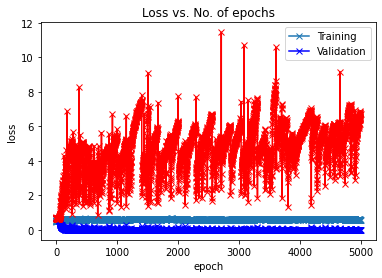

In [10]:
import matplotlib.pyplot as plt

def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [12]:
max([x['val_acc'] for x in history])

0.6898500919342041